# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
!pip install ipython-autotime
!pip install alphalens

     |████████████████████████████████| 24.0 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 107 kB 51.6 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 59.6 MB/s eta 0:00:01
  Created wheel for alphalens: filename=alphalens-0.4.0-py3-none-any.whl size=24027558 sha256=ddfc95afe03ffa53f9955c639673e6812a945d3f754a2a0d62bf72a4895bda5b
  Stored in directory: /home/jupyter/.cache/pip/wheels/10/a6/42/026fe89e82dbcde7f6f756465a10a045ada9902eb4592ce2d3
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39764 sha256=f16f15f1e5fbe19359122f719724a836edff1946efddf3259a5a07a4deffc8af
  Stored in directory: /home/jupyter/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built alphalens empyrical


In [7]:
### set path
import os
from pathlib import Path

path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'
#os.mkdir(path_data)

time: 735 µs (started: 2021-04-25 02:18:19 +00:00)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%load_ext autotime

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

time: 543 ms (started: 2021-04-25 02:16:46 +00:00)


In [4]:
sns.set_style('whitegrid')

time: 587 µs (started: 2021-04-25 02:16:51 +00:00)


In [5]:
idx = pd.IndexSlice

time: 390 µs (started: 2021-04-25 02:16:52 +00:00)


## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

time: 374 µs (started: 2021-04-25 02:17:40 +00:00)


### Get AlphaLens Input

Using next available prices.

In [23]:
def get_trade_prices(tickers):
    prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
                .set_index(['ticker','date'])
                .sort_index(level=['ticker','date']))
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

time: 678 µs (started: 2021-04-25 02:30:34 +00:00)


Reloading predictions.

In [24]:
best_predictions = (pd.read_csv(path_result / f'test_{lookahead:02}.csv', parse_dates=['date'])
                      .set_index(['ticker','date'])
                      .sort_index(level=['ticker','date']))            
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 470500 entries, ('1332.JP', Timestamp('2017-12-11 00:00:00')) to ('9990.JP', Timestamp('2019-12-27 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  470500 non-null  float64
 1   0       470500 non-null  float64
 2   1       470500 non-null  float64
 3   2       470500 non-null  float64
 4   3       470500 non-null  float64
 5   4       470500 non-null  float64
 6   5       470500 non-null  float64
 7   6       470500 non-null  float64
 8   7       470500 non-null  float64
 9   8       470500 non-null  float64
 10  9       470500 non-null  float64
dtypes: float64(11)
memory usage: 41.3+ MB
time: 1.21 s (started: 2021-04-25 02:30:43 +00:00)


In [25]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

time: 39.9 ms (started: 2021-04-25 02:30:51 +00:00)


In [38]:
factor = (best_predictions
          .iloc[:, :3]
          .mean(1)
          .tz_localize('UTC', level='date')
          .swaplevel()
          .dropna()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker']))

factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 450739 entries, (Timestamp('2017-12-11 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               450739 non-null  float64
 1   5D               450739 non-null  float64
 2   10D              450739 non-null  float64
 3   21D              450739 non-null  float64
 4   factor           450739 non-null  float64
 5   factor_quantile  450739 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.4+ MB
time: 7.82 s (started: 2021-04-25 02:39:58 +00:00)


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.148374,0.013818,-0.008531,0.008583,90532,20.085238
2,-0.036775,0.017319,-0.003421,0.006608,90058,19.980077
3,-0.034232,0.020935,-0.000989,0.006427,90062,19.980965
4,-0.032246,0.026341,0.001473,0.006390,90037,19.975418
5,-0.028746,0.124585,0.006917,0.008445,90050,19.978302


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,43.766,1.065,0.425,0.177
beta,-0.024,-0.028,-0.017,-0.006
Mean Period Wise Return Top Quantile (bps),145.632,27.814,13.622,6.190
Mean Period Wise Return Bottom Quantile (bps),-140.746,-27.130,-13.244,-6.114
Mean Period Wise Spread (bps),286.378,54.947,26.869,12.305


Information Analysis


,1D,5D,10D,21D
IC Mean,0.637,0.268,0.187,0.123
IC Std.,0.108,0.120,0.120,0.116
Risk-Adjusted IC,5.914,2.240,1.553,1.060
t-stat(IC),129.441,49.015,33.989,23.202
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-1.016,-0.195,-0.334,-0.356
IC Kurtosis,2.072,0.459,0.506,0.795


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.768,0.786,0.793,0.786
Quantile 2 Mean Turnover,0.787,0.793,0.796,0.793
Quantile 3 Mean Turnover,0.780,0.788,0.792,0.792
Quantile 4 Mean Turnover,0.789,0.793,0.798,0.796
Quantile 5 Mean Turnover,0.771,0.786,0.789,0.786


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.007,-0.004,-0.012,0.001


<Figure size 432x288 with 0 Axes>

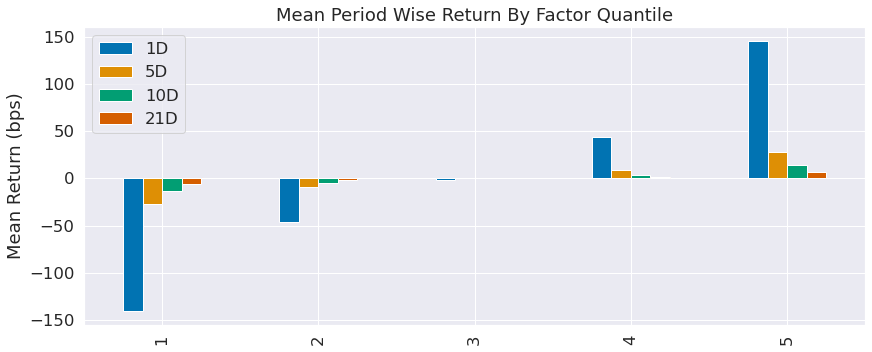

time: 20.8 s (started: 2021-04-25 02:42:18 +00:00)


In [39]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [42]:
t = 1
predictions = (pd.read_csv(path_result / f'test_{t:02}.csv', parse_dates=['date'])
                 .set_index(['ticker','date'])
                 .sort_index(level=['ticker','date'])   
                 .drop('y_test', axis=1))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 470500 entries, ('1332.JP', Timestamp('2017-12-11 00:00:00')) to ('9990.JP', Timestamp('2019-12-27 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       470500 non-null  float64
 1   1       470500 non-null  float64
 2   2       470500 non-null  float64
 3   3       470500 non-null  float64
 4   4       470500 non-null  float64
 5   5       470500 non-null  float64
 6   6       470500 non-null  float64
 7   7       470500 non-null  float64
 8   8       470500 non-null  float64
 9   9       470500 non-null  float64
dtypes: float64(10)
memory usage: 37.7+ MB
time: 1.22 s (started: 2021-04-25 02:46:31 +00:00)


In [43]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2017-12-11 00:00:00+00:00  1332.JP    0.002407
2017-12-12 00:00:00+00:00  1332.JP   -0.005762
2017-12-13 00:00:00+00:00  1332.JP    0.005483
2017-12-14 00:00:00+00:00  1332.JP    0.004905
2017-12-15 00:00:00+00:00  1332.JP    0.001226
dtype: float64

time: 92.2 ms (started: 2021-04-25 02:46:54 +00:00)


### Select next available trade prices

Using next available prices.

In [44]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB
time: 2min 55s (started: 2021-04-25 02:47:10 +00:00)


### Get AlphaLens Inputs

In [45]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 450739 entries, (Timestamp('2017-12-11 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               450739 non-null  float64
 1   5D               450739 non-null  float64
 2   10D              450739 non-null  float64
 3   21D              450739 non-null  float64
 4   factor           450739 non-null  float64
 5   factor_quantile  450739 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.4+ MB
time: 7.32 s (started: 2021-04-25 02:50:05 +00:00)


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.034534,0.015282,-0.003420,0.006827,90588,20.097662
2,-0.031039,0.019814,-0.002069,0.006414,90056,19.979633
3,-0.030447,0.022737,-0.001131,0.006352,90041,19.976306
4,-0.030321,0.023127,-0.000224,0.006392,90096,19.988508
5,-0.030102,0.029332,0.001351,0.006720,89958,19.957891


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.065,0.026,0.006,0.004
beta,0.030,0.033,0.018,0.018
Mean Period Wise Return Top Quantile (bps),3.317,1.224,0.448,0.123
Mean Period Wise Return Bottom Quantile (bps),-2.834,-1.180,-0.096,-0.099
Mean Period Wise Spread (bps),6.151,2.405,0.539,0.214


Information Analysis


,1D,5D,10D,21D
IC Mean,0.011,0.009,0.001,-0.001
IC Std.,0.106,0.110,0.106,0.107
Risk-Adjusted IC,0.100,0.082,0.009,-0.009
t-stat(IC),2.181,1.801,0.199,-0.198
p-value(IC),0.030,0.072,0.842,0.843
IC Skew,0.391,0.206,0.074,0.276
IC Kurtosis,1.198,0.827,0.604,1.089


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.685,0.768,0.788,0.792
Quantile 2 Mean Turnover,0.764,0.793,0.794,0.796
Quantile 3 Mean Turnover,0.772,0.794,0.795,0.798
Quantile 4 Mean Turnover,0.763,0.789,0.796,0.800
Quantile 5 Mean Turnover,0.693,0.754,0.775,0.790


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.196,0.072,0.032,0.009


<Figure size 432x288 with 0 Axes>

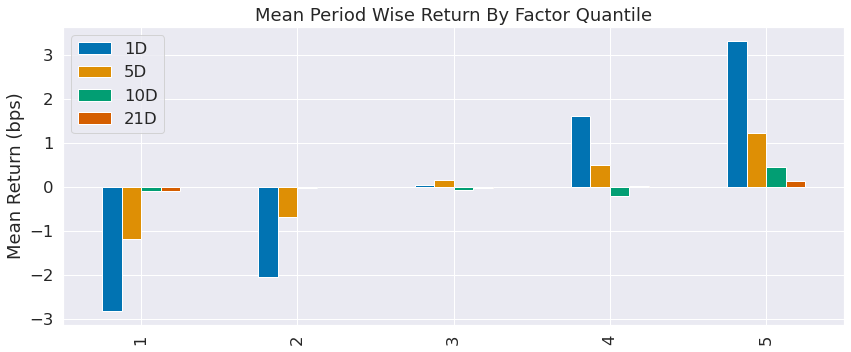

time: 20.7 s (started: 2021-04-25 02:50:13 +00:00)


In [46]:
create_summary_tear_sheet(factor_data)